In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [2]:
# Read local .csv downloaded from crime-data-explorer.fr.cloud.gov
df = pd.read_csv('hate_crime.csv')
df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


#### Should we keep the `ORI` column?
definition I found on the definition for ORI: A nine-character identifier assigned to an agency. Agencies must identify their ORI Number on the requisition forms in order to receive fingerprint supplies and training aids.
  - Could also consider using this number as a more uniform alternative for `incident_id`
  
#### What about `MULTIPLE_OFFENSE` and `MULTIPLE_BIAS`?
- Looks like the values are either 'S' or 'M'. We don't know what those mean, so should we drop these columns?

In [3]:
# Look at an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219577 entries, 0 to 219576
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   INCIDENT_ID               219577 non-null  int64  
 1   DATA_YEAR                 219577 non-null  int64  
 2   ORI                       219577 non-null  object 
 3   PUB_AGENCY_NAME           219577 non-null  object 
 4   PUB_AGENCY_UNIT           6431 non-null    object 
 5   AGENCY_TYPE_NAME          219577 non-null  object 
 6   STATE_ABBR                219577 non-null  object 
 7   STATE_NAME                219577 non-null  object 
 8   DIVISION_NAME             219577 non-null  object 
 9   REGION_NAME               219577 non-null  object 
 10  POPULATION_GROUP_CODE     219577 non-null  object 
 11  POPULATION_GROUP_DESC     219577 non-null  object 
 12  INCIDENT_DATE             219577 non-null  object 
 13  ADULT_VICTIM_COUNT        51411 non-null   f

In [4]:
# Dropping these because they are not needed;
# pub_agency_unit is mostly nulls and not necessary for county to be included
# juvenille_victim_count the column is unnecessary and has few values non-null 
df = df.drop(columns=['PUB_AGENCY_UNIT', 'JUVENILE_VICTIM_COUNT'])

In [5]:
df['OFFENDER_ETHNICITY'] = df['OFFENDER_ETHNICITY'].fillna('Unknown')
df['ADULT_VICTIM_COUNT'] = df['ADULT_VICTIM_COUNT'].fillna(0)
df['ADULT_OFFENDER_COUNT'] = df['ADULT_OFFENDER_COUNT'].fillna(0)
df['JUVENILE_OFFENDER_COUNT'] = df['JUVENILE_OFFENDER_COUNT'].fillna(0)
df['OFFENDER_RACE'] = df['OFFENDER_RACE'].fillna('Unknown')
df['TOTAL_INDIVIDUAL_VICTIMS'] = df['TOTAL_INDIVIDUAL_VICTIMS'].fillna('Unknown')

In [6]:
# Looking for nulls
df.isna().sum()

INCIDENT_ID                 0
DATA_YEAR                   0
ORI                         0
PUB_AGENCY_NAME             0
AGENCY_TYPE_NAME            0
STATE_ABBR                  0
STATE_NAME                  0
DIVISION_NAME               0
REGION_NAME                 0
POPULATION_GROUP_CODE       0
POPULATION_GROUP_DESC       0
INCIDENT_DATE               0
ADULT_VICTIM_COUNT          0
TOTAL_OFFENDER_COUNT        0
ADULT_OFFENDER_COUNT        0
JUVENILE_OFFENDER_COUNT     0
OFFENDER_RACE               0
OFFENDER_ETHNICITY          0
VICTIM_COUNT                0
OFFENSE_NAME                0
TOTAL_INDIVIDUAL_VICTIMS    0
LOCATION_NAME               0
BIAS_DESC                   0
VICTIM_TYPES                0
MULTIPLE_OFFENSE            0
MULTIPLE_BIAS               0
dtype: int64

In [7]:
df

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_CODE,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,City,AR,Arkansas,West South Central,South,5,...,White,Unknown,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,City,AR,Arkansas,West South Central,South,6,...,Black or African American,Unknown,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,City,AR,Arkansas,West South Central,South,3,...,Black or African American,Unknown,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,City,AR,Arkansas,West South Central,South,3,...,Black or African American,Unknown,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,City,AR,Arkansas,West South Central,South,3,...,Black or African American,Unknown,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219572,1318026,2020,WY0170100,Sheridan,City,WY,Wyoming,Mountain,West,5,...,White,Not Hispanic or Latino,2,Intimidation,2.0,Park/Playground,"Anti-Lesbian, Gay, Bisexual, or Transgender (M...",Individual,S,S
219573,1142103,2020,WY0210100,Evanston,City,WY,Wyoming,Mountain,West,5,...,Unknown,Unknown,1,Destruction/Damage/Vandalism of Property,0.0,Park/Playground,Anti-White,Government,S,S
219574,1318018,2020,WY0210100,Evanston,City,WY,Wyoming,Mountain,West,5,...,Black or African American,Not Hispanic or Latino,1,Aggravated Assault,1.0,Residence/Home,Anti-White,Individual,S,S
219575,1318022,2020,WY0210100,Evanston,City,WY,Wyoming,Mountain,West,5,...,White,Not Hispanic or Latino,1,Simple Assault,1.0,Residence/Home,Anti-Female,Individual,S,S


### What is the distribution of race for hate crime offenders?

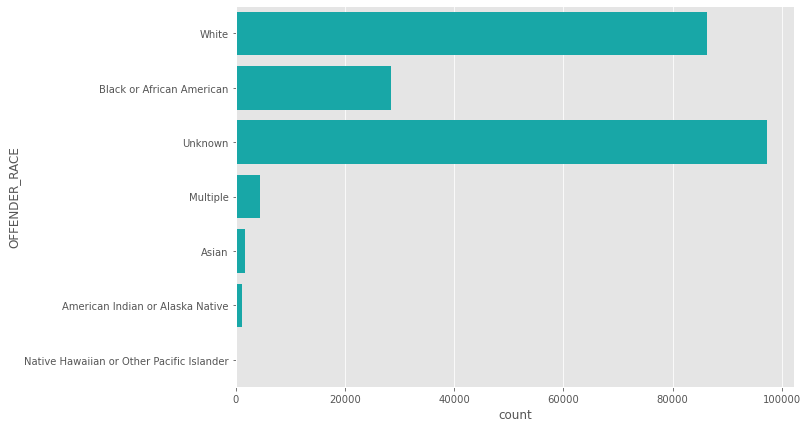

In [35]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(y="OFFENDER_RACE", data=df, color="c");

Takeaways: 
    - Most offenders are White
    - A large amount are unknown